## What’s Required

Autoencoders require 3 things:

    Encoding function
    Decoding function
    Loss function describing the amount of information loss between the compressed and decompressed representations of the data examples and the decompressed representation (i.e. a “loss” function).

The encoding/decoding functions are typically (parametric) neural nets and are differentiable with respect to the distance function. The differentiable part enables optimizing the parameters of the encoding/decoding functions to minimize the reconstruction loss.

## What Are They Good For

    Data Denoising
    Dimension Reduction
    Data Visualization (basically the same as 2, but plots)

For data denoising, think PCA, but nonlinear. In fact, if the encoder/decoder functions are linear, the result spans the space of the PCA solution. The nonlinear part is useful because they can capture, for example, multimodality in the feature space, which PCA can’t.


## In This Notebook 

    Simple Autoencoder
    Deep Autoencoder
    Convolution Autoencoder
    Build a Second Convolution Autoencoder to Denoise Images



## Data Loading and PreProcesssing

In [1]:
#  pip3 install pydot
from IPython.display import Image, SVG
'''
Scalable Vector Graphics (SVG) is an XML-based vector image format for two-dimensional 
graphics with support for interactivity and animation. 

The display call is similar to the ordinary print statement, but can handle different 
representations like images, html, latex, etc.

Links:
    https://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/IPython%20Kernel/Rich%20Output.ipynb
'''

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

from keras.utils.vis_utils import model_to_dot


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #model will be trained on GPU -1

Using TensorFlow backend.


In [15]:
## Loading Dataset: Loads the training and test data sets (ignoring class labels: Not Required)
(x_train, _), (x_test, _) = mnist.load_data() ## load_data(): will download the data directly fromm S3 on AWS

## Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

print(max_value, x_train.shape, x_test.shape)

255.0 (60000, 28, 28) (10000, 28, 28)


#### Discussion
The data set consists 3D arrays with 60K training and 10K test images. The images have a resolution of 28 x 28 (pixels).

In [23]:
## Reshaping the 3D arrays as matrices i.e. 2D
x_train_flattened = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flattened = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train_flattened.shape, x_test_flattened.shape)

(60000, 784) (10000, 784)


In [24]:
# adapt this if using `channels_first` image data format
x_train_img_mono = np.reshape(x_train, (len(x_train), x_train.shape[1], x_train.shape[2], 1))
x_test_img_mono = np.reshape(x_test, (len(x_test), x_test.shape[1], x_test.shape[2], 1))

print(x_train_img_mono.shape, x_test_img_mono.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Inputs

In [4]:
_, a,b = x_train.shape
print('Images that are to be used as input are having a shape of {} x {}'.format(a,b))

print('Enable Aspect Ratio Consistency for Encoded layer [y/n]')
enable_aspect_ratio_consistency = input()

if enable_aspect_ratio_consistency in ['Y', 'y', 'T', 't', 'True', 'true', 'TRUE']:
    ## Version1 -- Aspect ratio of the image is maintained such that the encoded image is still human readable (at least index/ seq missmmatch doesn't occur)
    # a_comp, b_comp 
    compression_ratio = range(2,16)
    val_a = [ ((a**2)/val)**0.5 for val in compression_ratio ] 
    val_b = [ ((b**2)/val)**0.5 for val in compression_ratio ] 

    poss_a_comp = [ int(i) for i in val_a if i-int(i) == 0.0 ]
    poss_b_comp = [ int(i) for i in val_b if i-int(i) == 0.0 ]

    uniq_compression_ratio = {}
    li = [ a**2/val**2 for val in poss_a_comp ] + [ b**2/val**2 for val in poss_b_comp ]
    for ele in li:
        uniq_compression_ratio[ele] = 1
    alllowed_compression_ratio_to_maintain_aspecct_ratio = list(uniq_compression_ratio.keys())

    print('Possible Compression Ratio which will be ablle to maintain compression ratio:',alllowed_compression_ratio_to_maintain_aspecct_ratio)
    print('Type the compression ratio you want to take:')
    comp_ratio_to_use = float(input())

    while comp_ratio_to_use not in alllowed_compression_ratio_to_maintain_aspecct_ratio:
        print('Input is not present in the list hence type availablle value again')
        comp_ratio_to_use = float(input())

    a_comp, b_comp  = int((a**2/comp_ratio_to_use)**0.5), int((b**2/comp_ratio_to_use)**0.5)
else:
    print('Enter the "a" in encoder image shape of axb ')
    a_comp = int(input())
    print('Enter the "b" in encoder image shape of axb ')
    b_comp = int(input())

print('Original Image dimension that is feeded : {} x {}'.format(a, b))
print('Encoded Image dimension to maintain aspect ratio : {} x {}'.format(a_comp, b_comp))


Images that are to be used as input are having a shape of 28 x 28
Enable Aspect Ratio Consistency for Encoded layer [y/n]
n
Enter the "a" in encoder image shape of axb 
4
Enter the "b" in encoder image shape of axb 
2
Original Image dimension that is feeded : 28 x 28
Encoded Image dimension to maintain aspect ratio : 4 x 2


## Simple Autoencoder
The encoder and decoder functions are each fully-connected neural layers. The encoder function uses a **ReLU activation function**, while the decoder function uses a **sigmoid activation function**.

- The **encoder layer** encodes the input image as a compressed representation in a reduced dimension. The compressed image typically looks garbled, nothing like the original image.
- The **decoder layer** decodes the encoded image back to the original dimension. The decoded image is a lossy reconstruction of the original image.



In our example, the compressed image has a dimension of 32.
- The encoder model reduces the dimension from the original **784-dimensional vector** to the encoded **32-dimensional vector**. 
- The decoder model restores the dimension from the encoded **32-dimensional vector** representation back to the original **784-dimensional vector**.

The **compression factor** is the ratio of the input dimension to the encoded dimension. In our case, the factor is ```24.5 = 784 / 32```.


 ------------------------------<<<<<Overall Architect>>>>>------------------------------
Defining the Overall Architect of Simple AutoEncoder
Input Dimension: 784
Encoding Dimension: 8
Compression factor: 98.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 6280      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               7056      
Total params: 13,336
Trainable params: 13,336
Non-trainable params: 0
_________________________________________________________________


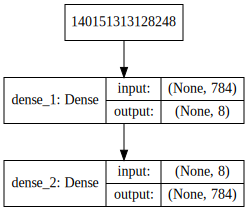


 ------------------------------<<<<<Encoder Layer>>>>>------------------------------
Defining the Architect to get Encoded Layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 6280      
Total params: 6,280
Trainable params: 6,280
Non-trainable params: 0
_________________________________________________________________


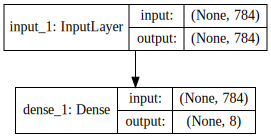

In [5]:
## Defining the Overall Architect
print('\n','-'*30+'<'*5+'Overall Architect'+'>'*5+'-'*30)
print('Defining the Overall Architect of Simple AutoEncoder')

input_dim = x_train_flattened.shape[1]
encoding_dim = a_comp * b_comp

compression_factor = float(input_dim) / encoding_dim
print('Input Dimension: {0}\nEncoding Dimension: {1}'.format(input_dim, encoding_dim))
print('Compression factor: %s' % compression_factor)

ae_model = Sequential()
ae_model.add(Dense(encoding_dim, input_shape=(input_dim,), activation='relu'))
ae_model.add(Dense(input_dim, activation='sigmoid'))

## Architect Summary
ae_model.summary()
display(SVG(model_to_dot(ae_model, show_shapes=True).create(prog='dot', format='svg')))


## Encoded Layer
print('\n','-'*30+'<'*5+'Encoder Layer'+'>'*5+'-'*30)
print('Defining the Architect to get Encoded Layer')

input_img = Input(shape=(input_dim,))
encoder_layer = ae_model.layers[0]
enc_model = Model(input_img, encoder_layer(input_img))

## Architect Summary
enc_model.summary()
display(SVG(model_to_dot(enc_model, show_shapes=True).create(prog='dot', format='svg')))

In [6]:
## Training
'''
We’ll iterate on the training data in batches of 256 in 50 epochs. 
Let’s also use the Adam optimizer and per-pixel binary crossentropy loss. 
The purpose of the loss function is to reconstruct an image similar to the input image.
'''

# optimizer= 'adam', 'adadelta', 'sgd'
# loss= 'binary_crossentropy', 'binary_crossentropy','mean_squared_error' 
# metrics= ['mae', 'acc']
ae_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

ae_model_history = ae_model.fit(x_train_flattened, x_train_flattened,
                                epochs=25,
                                batch_size=256,
                                shuffle=True,
                                validation_split=0.2,
                                # validation_data=(x_test_flattened, x_test_flattened),
                                verbose=1
                                )
print(type(ae_model))

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 2s 47us/step - loss: 0.0979 - mean_absolute_error: 0.2292 - acc: 0.0078 - val_loss: 0.0675 - val_mean_absolute_error: 0.1576 - val_acc: 0.0065
Epoch 2/25
48000/48000 [==============================] - 2s 34us/step - loss: 0.0604 - mean_absolute_error: 0.1458 - acc: 0.0115 - val_loss: 0.0528 - val_mean_absolute_error: 0.1318 - val_acc: 0.0128
Epoch 3/25
48000/48000 [==============================] - 2s 34us/step - loss: 0.0484 - mean_absolute_error: 0.1211 - acc: 0.0106 - val_loss: 0.0440 - val_mean_absolute_error: 0.1108 - val_acc: 0.0090
Epoch 4/25
48000/48000 [==============================] - 2s 35us/step - loss: 0.0424 - mean_absolute_error: 0.1060 - acc: 0.0090 - val_loss: 0.0406 - val_mean_absolute_error: 0.1019 - val_acc: 0.0099
Epoch 5/25
48000/48000 [==============================] - 2s 33us/step - loss: 0.0401 - mean_absolute_error: 0.1001 - acc: 0.0092 - val_loss: 0.03

Available Keys in Model:
	 dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


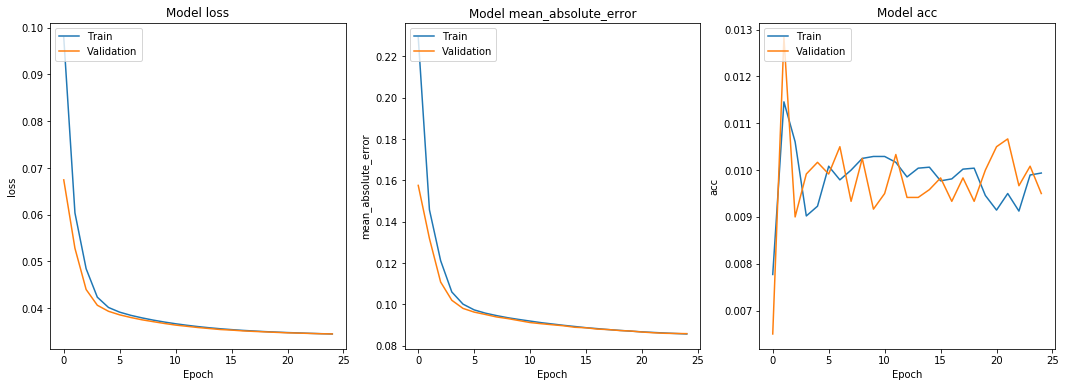

In [7]:
def mod_hist_plot():
    mod_hist = ae_model_history.history

    # list all data in history
    print('Available Keys in Model:\n\t', mod_hist.keys())

    plt.figure(figsize=(18, 6))
    thingsToPlot = [ ele for ele in mod_hist.keys() if 'val_' not in ele ]
    noOfPlots = len(thingsToPlot)
    ## Summarize history
    for i in range(noOfPlots):
        plt.subplot(1, noOfPlots, i+1)
        plt.plot(mod_hist[thingsToPlot[i]])
        plt.plot(mod_hist['val_'+thingsToPlot[i]])
        plt.title('Model '+thingsToPlot[i])
        plt.ylabel(thingsToPlot[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
mod_hist_plot()

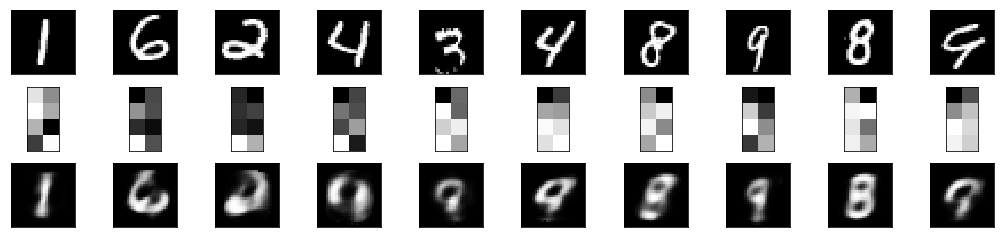

In [10]:
def plot_test_res_summary():
    noOfImagesToPrint = 10
    _,a,b = x_train.shape

    ## Predicting over Test Data
    encoded_imgs, decoded_imgs = enc_model.predict(x_test_flattened), ae_model.predict(x_test_flattened)

    ## randomly selecting the index
    np.random.seed(42)
    random_ind = np.random.randint(x_test_flattened.shape[0], size=noOfImagesToPrint)

    plt.figure(figsize=(18, 4))
    for i, image_idx in enumerate(random_ind):
        for plotData in [('Original', x_test_flattened, (a,b)), 
                         ('Encoded', encoded_imgs, (a_comp, b_comp)),
                         ('Decoded', decoded_imgs, (a,b))]:
            # plotting image
            if plotData[0] == 'Encoded':
                l = noOfImagesToPrint
            elif plotData[0] == 'Decoded':
                l = 2*noOfImagesToPrint
            else:
                l = 0
            loc = l + i + 1 
            ax = plt.subplot(3, noOfImagesToPrint, loc)
            plt.imshow(plotData[1][image_idx].reshape(plotData[2]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

    # num_images = 10
    # np.random.seed(42)
    # random_test_images = np.random.randint(x_test.shape[0], size=num_images)

    # encoded_imgs = enc_model.predict(x_test_flattened)
    # decoded_imgs = ae_model.predict(x_test_flattened)

    # plt.figure(figsize=(18, 4))

    # for i, image_idx in enumerate(random_test_images):
    #     # plot original image
    #     ax = plt.subplot(3, num_images, i + 1)
    #     plt.imshow(x_test_flattened[image_idx].reshape(28, 28))
    #     plt.gray()
    #     ax.get_xaxis().set_visible(False)
    #     ax.get_yaxis().set_visible(False)

    #     # plot encoded image
    #     ax = plt.subplot(3, num_images, num_images + i + 1)
    #     plt.imshow(encoded_imgs[image_idx].reshape(a_comp, b_comp))
    #     plt.gray()
    #     ax.get_xaxis().set_visible(False)
    #     ax.get_yaxis().set_visible(False)

    #     # plot reconstructed image
    #     ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    #     plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    #     plt.gray()
    #     ax.get_xaxis().set_visible(False)
    #     ax.get_yaxis().set_visible(False)
    # plt.show()
    
plot_test_res_summary()

## Deep Autoencoder

Above, we used single fully-connected layers for both the encoding and decoding models. Instead, we can stack multiple fully-connected layers to make each of the encoder and decoder functions deep.

We'll use 3 fully-connected layers for the encoding model with decreasing dimensions from 128 to 64 32 again. Likewise, we’ll add 3 fully-connected decoder layers that reconstruct the image back to 784 dimensions. Except for the last layer, we’ll use ReLU activation functions again.


 ------------------------------<<<<<Overall Architect>>>>>------------------------------
Defining the Overall Architect of Simple AutoEncoder
Input Dimension: 784
Encoding Dimension: 8
Compression factor: 98.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_______________________________________________________________

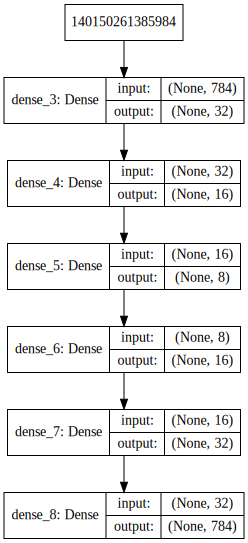


 ------------------------------<<<<<Encoder Layer>>>>>------------------------------
Defining the Architect to get Encoded Layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
Total params: 25,784
Trainable params: 25,784
Non-trainable params: 0
_________________________________________________________________


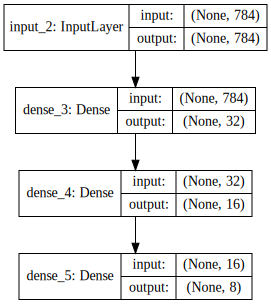

In [11]:
## Defining the Overall Architect
print('\n','-'*30+'<'*5+'Overall Architect'+'>'*5+'-'*30)
print('Defining the Overall Architect of Simple AutoEncoder')

input_dim = x_train_flattened.shape[1]
encoding_dim = a_comp * b_comp

compression_factor = float(input_dim) / encoding_dim
print('Input Dimension: {0}\nEncoding Dimension: {1}'.format(input_dim, encoding_dim))
print('Compression factor: %s' % compression_factor)

ae_model = Sequential()

# Encoder Layers
ae_model.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
ae_model.add(Dense(2 * encoding_dim, activation='relu'))
ae_model.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
ae_model.add(Dense(2 * encoding_dim, activation='relu'))
ae_model.add(Dense(4 * encoding_dim, activation='relu'))
ae_model.add(Dense(input_dim, activation='sigmoid'))

## Architect Summary
ae_model.summary()
display(SVG(model_to_dot(ae_model, show_shapes=True).create(prog='dot', format='svg')))


## Encoded Layer
print('\n','-'*30+'<'*5+'Encoder Layer'+'>'*5+'-'*30)
print('Defining the Architect to get Encoded Layer')

## Encoder Model
input_img = Input(shape=(input_dim,))
encoder_layer1 = ae_model.layers[0]
encoder_layer2 = ae_model.layers[1]
encoder_layer3 = ae_model.layers[2]
enc_model = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

## Architect Summary
enc_model.summary()
display(SVG(model_to_dot(enc_model, show_shapes=True).create(prog='dot', format='svg')))

In [12]:
## Training

# optimizer= 'adam', 'adadelta', 'sgd'
# loss= 'binary_crossentropy', 'binary_crossentropy','mean_squared_error' 
# metrics= ['mae', 'acc']
ae_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

ae_model_history = ae_model.fit(x_train_flattened, x_train_flattened,
                                epochs=25,
                                batch_size=256,
                                shuffle=True,
                                validation_split=0.2,
                                # validation_data=(x_test_flattened, x_test_flattened),
                                verbose=1
                                )
print(type(ae_model))

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 2s 52us/step - loss: 0.0897 - mean_absolute_error: 0.1947 - acc: 0.0079 - val_loss: 0.0636 - val_mean_absolute_error: 0.1422 - val_acc: 0.0113
Epoch 2/25
48000/48000 [==============================] - 2s 44us/step - loss: 0.0603 - mean_absolute_error: 0.1351 - acc: 0.0131 - val_loss: 0.0556 - val_mean_absolute_error: 0.1274 - val_acc: 0.0125
Epoch 3/25
48000/48000 [==============================] - 2s 46us/step - loss: 0.0525 - mean_absolute_error: 0.1206 - acc: 0.0112 - val_loss: 0.0476 - val_mean_absolute_error: 0.1111 - val_acc: 0.0121
Epoch 4/25
48000/48000 [==============================] - 2s 47us/step - loss: 0.0454 - mean_absolute_error: 0.1059 - acc: 0.0137 - val_loss: 0.0435 - val_mean_absolute_error: 0.1027 - val_acc: 0.0173
Epoch 5/25
48000/48000 [==============================] - 2s 46us/step - loss: 0.0425 - mean_absolute_error: 0.1003 - acc: 0.0132 - val_loss: 0.04

Available Keys in Model:
	 dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


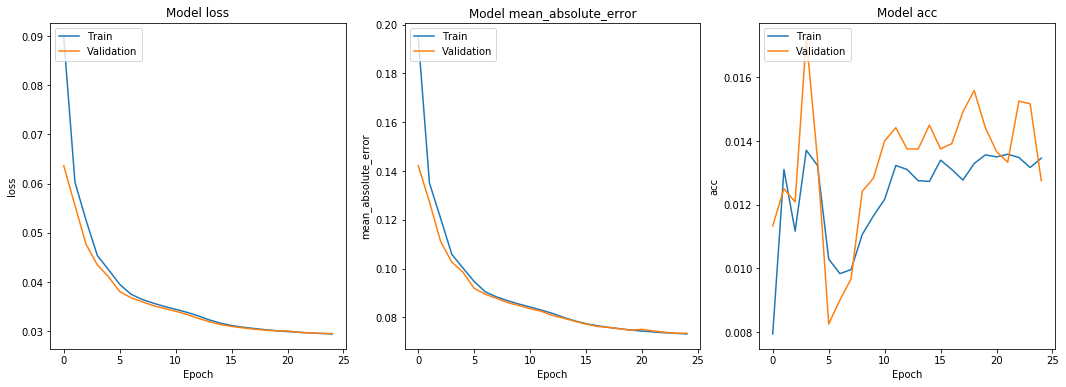

In [13]:
mod_hist_plot()

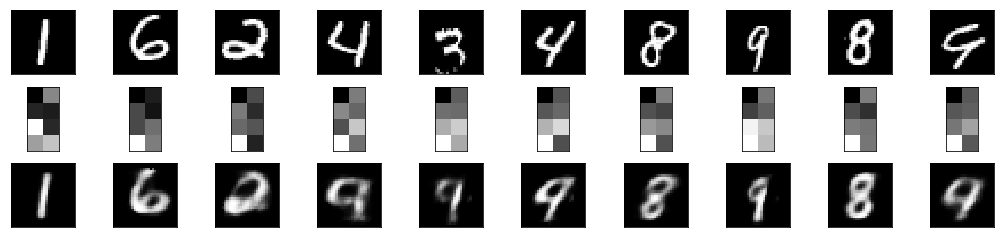

In [14]:
plot_test_res_summary()

## Convolutional Autoencoder
Now that we've explored deep autoencoders, let's use a convolutional autoencoder instead, given that the input objects are images. What this means is our encoding and decoding models will be convolutional neural networks instead of fully-connected networks.

Again, Keras makes this very easy for us. Before we get started though, we need to reshapes the images back to 28 x 28 x 1 for the convnets. The 1 is for 1 channel because black and white. If we had RGB color, there would be 3 channels.

In [ ]:
x_train_conv = x_train.reshape((len(x_train), 28, 28, 1))
x_test_conv = x_test.reshape((len(x_test), 28, 28, 1))

To build the convolutional autoencoder, we'll make use of Conv2D and MaxPooling2D layers for the encoder and Conv2D and UpSampling2D layers for the decoder. The encoded images are transformed to a 3D array of dimensions 4 x 4 x 8, but to visualize the encoding, we'll flatten it to a vector of length 128. I tried to use an encoding dimension of 32 like above, but I kept getting subpar results.

After the flattening layer, we reshape the image back to a 4 x 4 x 8 array before upsampling back to a 28 x 28 x 1 image.

In [ ]:
ae_model = Sequential()

# Encoder Layers
ae_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train_conv.shape[1:]))
ae_model.add(MaxPooling2D((2, 2), padding='same'))
ae_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
ae_model.add(MaxPooling2D((2, 2), padding='same'))
ae_model.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
ae_model.add(Flatten())
ae_model.add(Reshape((4, 4, 8)))

# Decoder Layers
ae_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
ae_model.add(UpSampling2D((2, 2)))
ae_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
ae_model.add(UpSampling2D((2, 2)))
ae_model.add(Conv2D(16, (3, 3), activation='relu'))
ae_model.add(UpSampling2D((2, 2)))
ae_model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

ae_model.summary()

In [ ]:
## Encoder Model
enc_model = Model(inputs= ae_model.input, outputs= ae_model.get_layer('flatten_1').output)

enc_model.summary()
SVG(model_to_dot(enc_model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
## Training Model

# optimizer= 'adam', 'adadelta', 'sgd'
# loss= 'binary_crossentropy', 'binary_crossentropy','mean_squared_error' 
# metrics= ['mae', 'acc']
ae_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

ae_model_history = ae_model.fit(x_train_conv, x_train_conv,
                                epochs=25,
                                batch_size=256,
                                shuffle=True,
                                validation_split=0.2,
                                # validation_data=(x_test_flattened, x_test_flattened),
                                verbose=1
                                )
print(type(ae_model))

In [ ]:
mod_hist_plot()

In [ ]:
plot_test_res_summary()

## Denoising Images with the Convolutional Autoencoder

Let’s add bit of noise to the test images and see how good the convolutional autoencoder is at removing the noise.

In [27]:
## adding noise to the image (monotone)
noise_factor = 0.5

x_train_noisy = x_train_img_mono + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_img_mono.shape)
x_test_noisy = x_test_img_mono + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_img_mono.shape)

## Clip (limit) the values in an array
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


 ------------------------------<<<<<Overall Architect>>>>>------------------------------
Defining the Overall Architect of Simple AutoEncoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 32)          9248      

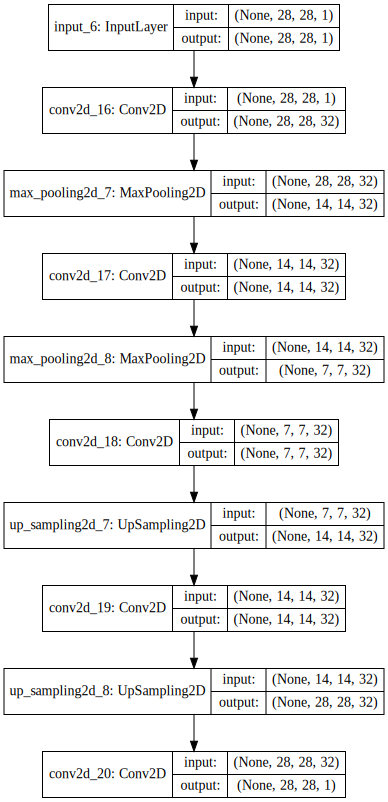


 ------------------------------<<<<<Encoder Layer>>>>>------------------------------
Defining the Architect to get Encoded Layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


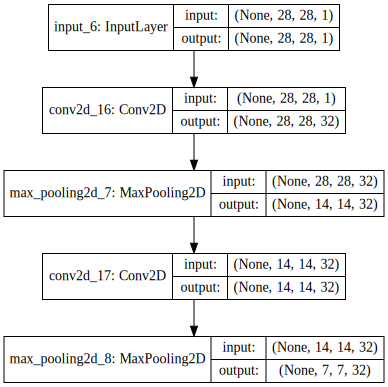

In [38]:
## Defining the Overall Architect
print('\n','-'*30+'<'*5+'Overall Architect'+'>'*5+'-'*30)
print('Defining the Overall Architect of Simple AutoEncoder')

input_dim = x_train_noisy.shape[1:]

# encoding_dim = a_comp * b_comp

# compression_factor = float(input_dim) / encoding_dim
# print('Input Dimension: {0}\nEncoding Dimension: {1}'.format(input_dim, encoding_dim))
# print('Compression factor: %s' % compression_factor)

# Encoder Layers
input_img = Input(shape=input_dim)  # adapt this if using `channels_first` image data format
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

# Decoder Layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

ae_model = Model(input_img, decoded)


## Architect Summary
ae_model.summary()
display(SVG(model_to_dot(ae_model, show_shapes=True).create(prog='dot', format='svg')))


## Encoded Layer
print('\n','-'*30+'<'*5+'Encoder Layer'+'>'*5+'-'*30)
print('Defining the Architect to get Encoded Layer')

## Encoder Model
# input_img = Input(shape=(input_dim,))
# encoder_layer1 = ae_model.layers[0]
# encoder_layer2 = ae_model.layers[1]
# encoder_layer3 = ae_model.layers[2]
# enc_model = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
enc_model = Model(input_img, encoded)


## Architect Summary
enc_model.summary()
display(SVG(model_to_dot(enc_model, show_shapes=True).create(prog='dot', format='svg')))

In [52]:
## Training

# optimizer= 'adam', 'adadelta', 'sgd'
# loss= 'binary_crossentropy', 'binary_crossentropy','mean_squared_error' 
# metrics= ['mae', 'acc']
# ae_model.compile(optimizer='adadelta', loss='binary_crossentropy')
ae_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

ae_model_history = ae_model.fit(x_train_noisy, x_train_noisy,
                                epochs=2,
                                # epochs=25,
                                batch_size=256,
                                shuffle=True,
                                validation_split=0.2,
                                # validation_data=(x_test_flattened, x_test_flattened),
                                verbose=1
                                )
print(type(ae_model))

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 181s 4ms/step - loss: 0.0772 - mean_absolute_error: 0.2219 - acc: 0.4743 - val_loss: 0.0749 - val_mean_absolute_error: 0.2183 - val_acc: 0.4761
Epoch 2/2
48000/48000 [==============================] - 169s 4ms/step - loss: 0.0736 - mean_absolute_error: 0.2161 - acc: 0.4770 - val_loss: 0.0723 - val_mean_absolute_error: 0.2148 - val_acc: 0.4774
<class 'keras.engine.training.Model'>


Available Keys in Model:
	 dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


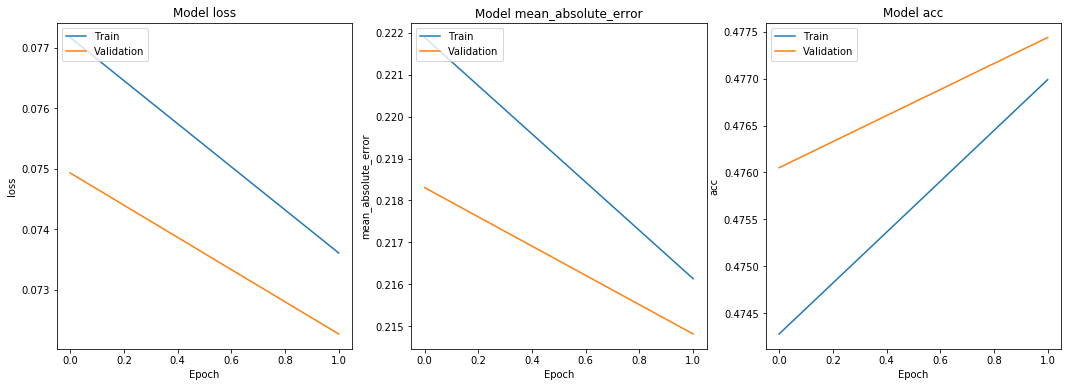

In [53]:
mod_hist_plot()

ValueError: cannot reshape array of size 1568 into shape (4,2)

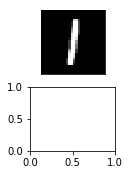

In [54]:
def plot_test_res_summary(arry):
    noOfImagesToPrint = 10
    _,a,b = x_train.shape

    ## Predicting over Test Data
    encoded_imgs, decoded_imgs = enc_model.predict(arry), ae_model.predict(arry)

    ## randomly selecting the index
    np.random.seed(42)
    random_ind = np.random.randint(arry.shape[0], size=noOfImagesToPrint)

    plt.figure(figsize=(18, 4))
    for i, image_idx in enumerate(random_ind):
        for plotData in [('Original', x_test_flattened, (a,b)), 
                         ('Encoded', encoded_imgs, (a_comp, b_comp)),
                         ('Decoded', decoded_imgs, (a,b))]:
            # plotting image
            if plotData[0] == 'Encoded':
                l = noOfImagesToPrint
            elif plotData[0] == 'Decoded':
                l = 2*noOfImagesToPrint
            else:
                l = 0
            loc = l + i + 1 
            ax = plt.subplot(3, noOfImagesToPrint, loc)
            plt.imshow(plotData[1][image_idx].reshape(plotData[2]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

    # num_images = 10
    # np.random.seed(42)
    # random_test_images = np.random.randint(x_test.shape[0], size=num_images)

    # encoded_imgs = enc_model.predict(x_test_flattened)
    # decoded_imgs = ae_model.predict(x_test_flattened)

    # plt.figure(figsize=(18, 4))

    # for i, image_idx in enumerate(random_test_images):
    #     # plot original image
    #     ax = plt.subplot(3, num_images, i + 1)
    #     plt.imshow(x_test_flattened[image_idx].reshape(28, 28))
    #     plt.gray()
    #     ax.get_xaxis().set_visible(False)
    #     ax.get_yaxis().set_visible(False)

    #     # plot encoded image
    #     ax = plt.subplot(3, num_images, num_images + i + 1)
    #     plt.imshow(encoded_imgs[image_idx].reshape(a_comp, b_comp))
    #     plt.gray()
    #     ax.get_xaxis().set_visible(False)
    #     ax.get_yaxis().set_visible(False)

    #     # plot reconstructed image
    #     ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    #     plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    #     plt.gray()
    #     ax.get_xaxis().set_visible(False)
    #     ax.get_yaxis().set_visible(False)
    # plt.show()
    
plot_test_res_summary(x_test_noisy)

In [65]:
arry = x_train_noisy.copy()


arry = arry
# noOfImagesToPrint = 10
# _,a,b = arry.shape[0:3]

# ## Predicting over Test Data
# encoded_imgs, decoded_imgs = enc_model.predict(arry), ae_model.predict(arry)

In [70]:
arry

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.47442143],
         [0.79042529],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.31815255],
         [0.        ],
         [0.23802129],
         ...,
         [0.        ],
         [0.        ],
         [0.21197153]],

        ...,

        [[0.        ],
         [0.        ],
         [1.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.50784347]],

        [[0.        ],
         [0.62582574],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.15710187],
         [0.        ],
         ...,
         [0.        ],
         [0.14888013],
         [0.        ]]],


       [[[0.14177904],
         [0.        ],
         [0.18

In [ ]:




## randomly selecting the index
np.random.seed(42)
random_ind = np.random.randint(arry.shape[0], size=noOfImagesToPrint)

plt.figure(figsize=(18, 4))
for i, image_idx in enumerate(random_ind):
    for plotData in [('Original', x_test_flattened, (a,b)), 
                     ('Encoded', encoded_imgs, (a_comp, b_comp)),
                     ('Decoded', decoded_imgs, (a,b))]:
        # plotting image
        if plotData[0] == 'Encoded':
            l = noOfImagesToPrint
        elif plotData[0] == 'Decoded':
            l = 2*noOfImagesToPrint
        else:
            l = 0
        loc = l + i + 1 
        ax = plt.subplot(3, noOfImagesToPrint, loc)
        plt.imshow(plotData[1][image_idx].reshape(plotData[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## Sequence-to-sequence autoencoder

If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

In [ ]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

## Variational autoencoder (VAE)

**What is a variational autoencoder?**

It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

**How does a variational autoencoder work?**

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.


In [ ]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])


decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)



# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

##  Convolutional Autoencoder - Take 2

we need to reshapes the images back to 28 x 28 x 1 for the convnets. The 1 is for 1 channel because black and white. If we had RGB color, there would be 3 channels.

So what happened above? We taught the autoencoder how to reconstruct the original image, but we didn’t quite teach the autoencoder how to remove noise.

One more thing: this time, let’s use (x_train_noisy, x_train) as training data and (x_test_noisy, x_test) as validation data. In doing so, we’re teaching the autoencoder how to denoise the input images.

In [ ]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

In [ ]:
## Training
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

In [ ]:
# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Types of autoencoder :**
The four following types of autoencoders will be described:
1. Vanilla autoencoder
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Regularized autoencoder


1. **Vanilla autoencoder**

In its simplest form, the autoencoder is a three layers net, i.e. a neural net with one hidden layer. The input and output are the same, and we learn how to reconstruct the input, for example using the **adam optimizer** and the **mean squared error loss function**.

Here, we see that we have an **undercomplete** autoencoder as the hidden layer dimension is smaller than the input. This constraint will impose our neural net to learn a compressed representation of data.


2. **Multilayer autoencoder**

If one hidden layer is not enough, we can obviously extend the autoencoder to more hidden layers.

Now our implementation uses many hidden layers instead of just one. Any of the hidden layers can be picked as the feature representation but we will make the network symmetrical and use the middle-most layer.


3. **Convolutional autoencoder**

We may also ask ourselves: can autoencoders be used with Convolutions instead of Fully-connected layers ?

The answer is yes and the principle is the same, but using images (3D vectors) instead of flattened 1D vectors. The input image is downsampled to give a latent representation of smaller dimensions and force the autoencoder to learn a compressed version of the images.


4. **Regularized autoencoder**
There are other ways we can constraint the reconstruction of an autoencoder than to impose a hidden layer of smaller dimension than the input. Rather than limiting the model capacity by keeping the encoder and decoder shallow and the code size small, regularized autoencoders use a loss function that encourages the model to have other properties besides the ability to copy its input to its output. In practice, we usually find two types of regularized autoencoder: the sparse autoencoder and the denoising autoencoder.


**Sparse autoencoder** : 
Sparse autoencoders are typically used to learn features for another task such as classification. An autoencoder that has been regularized to be sparse must respond to unique statistical features of the dataset it has been trained on, rather than simply acting as an identity function. In this way, training to perform the copying task with a sparsity penalty can yield a model that has learned useful features as a byproduct.

Another way we can constraint the reconstruction of autoencoder is to impose a constraint in its loss. We could, for example, add a reguralization term in the loss function. Doing this will make our autoencoder learn sparse representation of data.

Notice in our hidden layer, we added an l1 activity regularizer, that will apply a penalty to the loss function during the optimization phase. As a result, the representation is now sparser compared to the vanilla autoencoder.


**Denoising autoencoder** : 
Rather than adding a penalty to the loss function, we can obtain an autoencoder that learns something useful by changing the reconstruction error term of the loss function. This can be done by **adding some noise** of the input image and make the autoencoder learn to remove it. By this means, the encoder will extract the most important features and learn a robuster representation of the data.

In [ ]:
# https://medium.com/datadriveninvestor/deep-learning-different-types-of-autoencoders-41d4fa5f7570

Undercomplete Autoencoders

Sparse Autoencoders

Denoising Autoencoders(DAE)

Contractive Autoencoders(CAE)

Stacked Denoising Autoencoders

Deep Autoencoders